# Chapter 29 - Approximate Synchronization by Single Inhibitory Pulse

In [1]:
import numpy as np
import logging
import math

from bmtk.builder.networks import NetworkBuilder

n_E =10

net = NetworkBuilder('network')
net.add_nodes(N=n_E, pop_name='Exc',     # N = number of excitatory cells
        model_type='biophysical',
        model_template='hoc:RTMExcCell', # RTMExcCell hoc definition
        morphology='blank.swc')

c:\users\strou\anaconda3\envs\py2env\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
net.build()
net.save_nodes(output_dir='network')

In [3]:
n_In=10
extnet = NetworkBuilder('extnet')
extnet.add_nodes(N=n_In,pop_name='Inp',
            potential='exc',
            model_type='virtual')

BMTK does not allow individual nodes to start with distinct initial voltages. This is exactly what we need. To accomplish this, we will add a unique synaptic input to all of our cells to create initial voltages.

First, we need an equation that will match with the initial voltages in Borger's example. The initial voltages are given in the first vector. 

 init_volt=[-58.6290, -62.4873, -64.7941, -67.1735, -69.9618, -73.3491, -77.4968, -82.5814, -88.8151, -96.3579]

graphing and fitting a 3rd order polynomial to this data yields the following equation:
    y = -0.0452x3 + 0.4511x2 - 4.1178x - 55.204
    

In [4]:
def one_each(source, target):
    if source['node_id']==target['node_id']:
        return 1
    return 0

def set_syn_weight(source, target):
    sec_x = 0.5
    sec_id = 0
    x=target['node_id']
    a=1
    voltage = (-0.0452*x**3 + 0.4511*x**2 - 4.1178*x - 55.204)
    syn_weight = a/(voltage* (math.exp(-1/0.2) - math.exp(-1/0.1)))
    print(syn_weight)                                
    return syn_weight, sec_x, sec_id

conn=extnet.add_edges(source={'pop_name':'Inp'}, target=net.nodes(),
                    connection_rule=one_each,              
                    delay=0,
                    weight_function=None,
                    target_sections=['soma'],
                    distance_range=[0.0, 0.00000000001],
                    dynamics_params='PING_InhToExc.json',
                    model_template='Exp2Syn')

conn.add_properties(['syn_weight','sec_x','sec_id'],
                    rule=set_syn_weight, 
                    dtypes=[np.float, np.uint, np.uint])

In [5]:
extnet.build()
extnet.save_nodes(output_dir='network')
extnet.save_edges(output_dir='network')

-2.70668688424
-2.53615650032
-2.4101234702
-2.30878849217
-2.21854573629
-2.1295357798
-2.0347404317
-1.92978462342
-1.81294398772
-1.68501185505


### add spike train to our virtual cells

In [6]:
from bmtk.utils.reports.spike_trains import SpikeTrains

spikes = SpikeTrains(population='extnet')
for i in range(30):
    spikes.add_spike(node_id=i,timestamp=0)
spikes.to_sonata('input/Splay.h5')

In [7]:
import h5py

i_ext=[0,0,0,0,0]
for i in range(25):
    i_ext.append(1.2)
print(i_ext)
dts = [1]
gids = "all"

#hf.close() # Uncomment this line temporarily if you receive 'file already open error'

hf = h5py.File("input/amps.h5", 'w')

hf.create_dataset("amplitudes", data=[i_ext])
hf.create_dataset("gids", data=gids)
hf.create_dataset("dts", data=dts)

hf.close()

[0, 0, 0, 0, 0, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2]


Build the simulation environment. Has been edited for you

In [8]:
#from bmtk.utils.sim_setup import build_env_bionet

#build_env_bionet(base_dir='.',
                 #network_dir='network',
                 #tstop=30.0, dt=0.1,
                 #report_vars=['v'],     # Record membrane potential and calcium (default soma)
                #spikes_inputs=[('extnet',   # Name of population which spikes will be generated for
                                #'input/Splay.h5')],
                 #include_examples=False,    # Copies components files
                 #compile_mechanisms=False   # Will try to compile NEURON mechanisms
                #)

Run the Simulation

In [9]:
from bmtk.simulator import bionet


conf = bionet.Config.from_json('simulation_config.json')
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2021-01-25 23:20:28,523 [INFO] Building cells.
2021-01-25 23:20:28,535 [INFO] Building recurrent connections
2021-01-25 23:20:28,545 [INFO] Building virtual cell stimulations for extnet_spikes
2021-01-25 23:20:28,589 [INFO] Running simulation for 30.000 ms with the time step 0.100 ms
2021-01-25 23:20:28,605 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2021-01-25 23:20:28,621 [INFO] Block save every 300 steps
2021-01-25 23:20:28,696 [INFO]     step:300 t_sim:30.00 ms
2021-01-25 23:20:28,719 [INFO] Simulation completed in 0.129 seconds 


In [10]:
from bmtk.utils.reports.compartment import CompartmentReport

pop_name = 'Exc'
report = CompartmentReport('output/v_report.h5',
population=pop_name, mode='r')
v_trace=[]
for i in range(10):
    v_trace.append(report.data(node_id=i))
time = np.arange(report.tstart(), report.tstop(), report.dt())


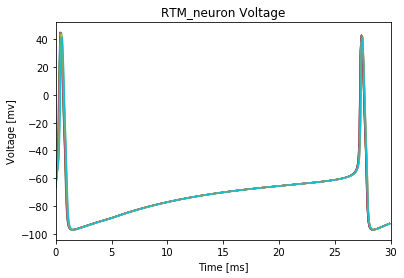

In [12]:
import matplotlib.pyplot as plt
for i in range(10):
    plt.plot(time, v_trace[i])
plt.ylabel('Voltage [mv]')
plt.xlabel('Time [ms]')
plt.title('RTM_neuron Voltage')
plt.xlim([0,30])
#plt.ylim([-100,-66])
plt.show()